In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np

/home/ollie/pscholz/tripyview_github


In [2]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path ='/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'zmeantransects_clim'

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')

vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [1979,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
which_clim= 'phc3'
clim_path = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2 
do_rescale= None
which_dpi = 300
do_contour= True
do_ylog   = True

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    for ii,ipath in enumerate(input_paths):
        # print(ii, ipath, ipath[0])
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path is not None) and (ref_path is not "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)

#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac
if climit   is not None: cinfo['climit']=climit
if chist    is not None: cinfo['chist' ]=chist
if ctresh   is not None: cinfo['ctresh']=ctresh    
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path is not "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names     

#________________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region is 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))       

 > found *.pckl file: /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/3/


In [4]:
#___LOAD CLIMATOLOGY_____________________________________________________________________________________
clim_vname= vname
if vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname: 
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim            = tpv.load_climatology(mesh, clim_path, clim_vname)
    clim_zmtransect = tpv.load_zmeantransect_fesom2(mesh, clim, box, do_compute=True, diagpath='/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/1/')
else: raise ValueError('climatology not supported for choosen vname')        
del(clim)

#___LOAD FESOM2 DATA____________________________________________________________________________________
list_zmtransects = list()
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    data            = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript, do_info=False, do_zarithm=None)
    data_zmtransect = tpv.load_zmeantransect_fesom2(mesh, data, box, do_compute=True)
    data_zmtransect = tpv.do_transect_anomaly(data_zmtransect, clim_zmtransect)
    list_zmtransects.append(data_zmtransect)
    del(data, data_zmtransect)    
del(clim_zmtransect)        

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/3/ TKE


--> histo: cmin, cmax =  -1.774291381245575 1.7516506625247632
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -1.77, 'cmax': 1.75, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fa4ed7c6790>, 'clevel': array([-1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8,
       -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,
        0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,
        1.5,  1.6,  1.7,  1.8])}


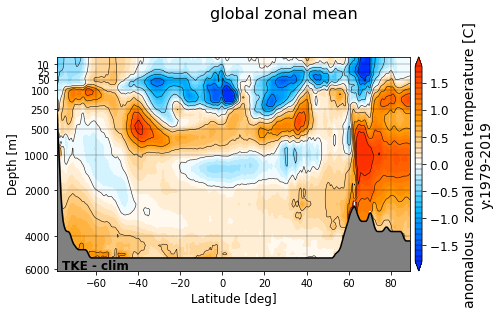

In [7]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = list_zmtransects[0][0][sname].attrs['str_lsave']
strans = list_zmtransects[0][0][vname].attrs['transect_name'].replace(' ','_').lower()
if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, strans, slabel) 
ncolumn= np.min([ncolumn,len(list_zmtransects)])        
nrow   = np.ceil(len(list_zmtransects)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
fig, ax, cbar = tpv.plot_zmeantransects(list_zmtransects, cinfo=cinfo, figsize=[ncolumn*7, nrow*3.5], n_rc=[nrow, ncolumn], 
                do_rescale=do_rescale, pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.05, 0.85,0.90], do_ylog=do_ylog,
                do_save = spath, save_dpi=which_dpi, do_contour=do_contour )